In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Creating Some Constants
batch_size = 32
CHANNELS = 1

In [6]:
# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
          '/content/drive/MyDrive/Colab Notebooks/Alzheimers Classification/Alzheimer_s Dataset/train',
          shuffle = True,
          image_size = (176,208),
          batch_size = batch_size )

Found 5311 files belonging to 4 classes.


In [25]:
# Lets define class name
class_name = dataset.class_names
class_name

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

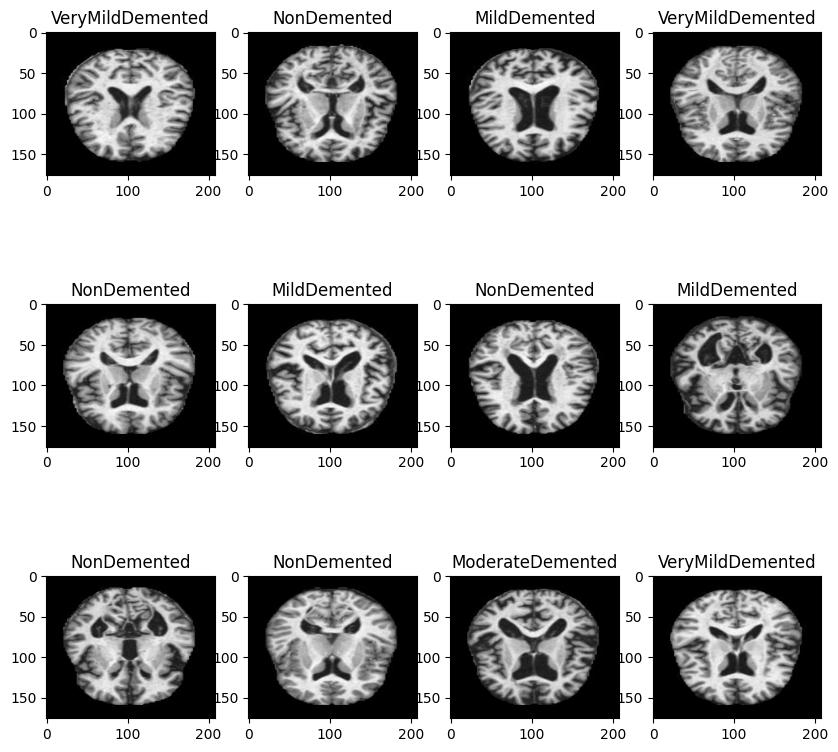

In [8]:
# Lets see some images from each class

plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_name[label_batch[i]])

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):

  ds_size = len(ds)

  if shuffle:
      ds = ds. shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds. skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
print("Training Size: ", len(train_ds))
print("Validation Size: ", len(val_ds))
print("Test Size: ", len(test_ds))

Training Size:  132
Validation Size:  16
Test Size:  18


In [12]:
# For confirming the define function is working properly or not
train_size = 0.8
len(dataset) * train_size

132.8

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1.0/255)])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)])

**Building Model**

In [16]:
model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 176, 208, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(4, activation='softmax')])


In [17]:
model.build(input_shape = (32, 176, 208, 3))

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 176, 208, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 176, 208, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 174, 206, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 87, 103, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 85, 101, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 42, 50, 64)          0         
 g2D)                                                 

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy'])

In [20]:
history = model.fit(
          train_ds,
          epochs = 10,
          batch_size = 32,
          verbose = 1,
          validation_data = val_ds
)

Epoch 1/10
132/132 [==============================] - 476s 3s/step - loss: 1.0645 - accuracy: 0.5022 - val_loss: 1.0441 - val_accuracy: 0.5625
Epoch 2/10
132/132 [==============================] - 378s 3s/step - loss: 1.0121 - accuracy: 0.5200 - val_loss: 0.9691 - val_accuracy: 0.5449
Epoch 3/10
132/132 [==============================] - 391s 3s/step - loss: 0.9457 - accuracy: 0.5349 - val_loss: 0.8883 - val_accuracy: 0.5762
Epoch 4/10
132/132 [==============================] - 380s 3s/step - loss: 0.9235 - accuracy: 0.5411 - val_loss: 0.8560 - val_accuracy: 0.5664
Epoch 5/10
132/132 [==============================] - 380s 3s/step - loss: 0.9192 - accuracy: 0.5522 - val_loss: 0.8443 - val_accuracy: 0.5762
Epoch 6/10
132/132 [==============================] - 372s 3s/step - loss: 0.9088 - accuracy: 0.5586 - val_loss: 0.8443 - val_accuracy: 0.5801
Epoch 7/10
132/132 [==============================] - 380s 3s/step - loss: 0.9009 - accuracy: 0.5645 - val_loss: 0.8376 - val_accuracy: 0.5840

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

**Plotting the loss function in the graph to understand it better**

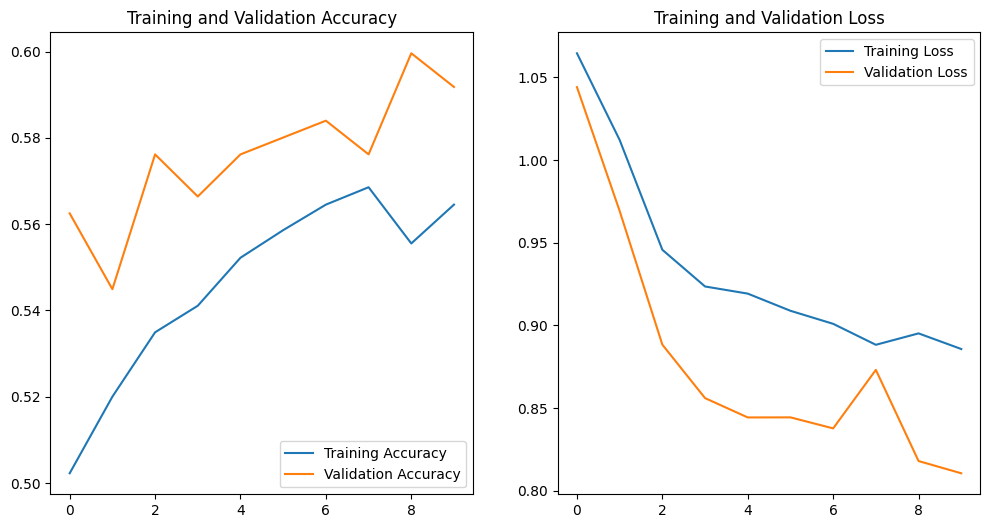

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: VeryMildDemented
1/1 [==============================] - 1s 1s/step
predicted label: VeryMildDemented


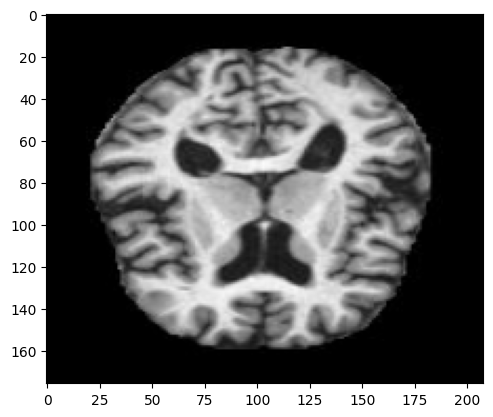

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])